In [2]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore

In [14]:
def max_abs_scale(series):
    return series / series.abs().max()

bar_width = 0.10
text_order = ["1Ko", "5Ko", "12Ko"]


dfe = pd.read_csv("./result/energy.csv")

dfm = pd.read_csv("./result/result.csv")  

dfe.head(30)

,duration_seconds,cpu0_package_joules,cpu0_dram_joules,cpu1_package_joules,cpu1_dram_joules,schema,text,cpu_count
0,4.856478,498.746948,66.205992,481.705933,60.320923,S3,5Ko,2
1,4.521211,467.883057,61.776902,445.398560,55.947862,S3,5Ko,2
2,4.713429,482.553162,64.303391,469.899841,58.316149,S3,5Ko,2
3,4.623586,477.164124,63.117824,456.637390,57.416035,S3,5Ko,2
4,4.970805,512.913513,67.792556,491.084656,61.792645,S3,5Ko,2
5,4.688302,480.360107,64.060779,468.401245,58.205515,S3,5Ko,2
6,4.746511,490.080994,64.577169,469.114258,59.009147,S3,5Ko,2
7,4.991440,510.292969,68.058194,498.245117,61.927377,S3,5Ko,2
8,4.788558,488.296997,65.109930,480.143738,59.679364,S3,5Ko,2
9,4.679928,482.520020,63.681675,464.080261,58.390828,S3,5Ko,2


Energy data frame pre-processing 

In [9]:
energy_features = [
    "cpu0_package_joules",
    "cpu1_package_joules"
]

# dfte : Data Frame Total Energy 
dfte = (
    dfe.copy()
    .assign(
        energy=lambda df: df[energy_features].sum(axis=1)
    )
    .groupby(['schema', 'text'], as_index=False)['energy']
    .agg(std_energy='std', mean_energys='mean')
    .assign(
        mean_energys=lambda df: df.groupby('text')['mean_energys'].transform(max_abs_scale),
        text=lambda df: pd.Categorical(df['text'], categories=text_order, ordered=True),
    )
    .sort_values(['schema', 'text'])
)

# dfte.head()


,schema,text,std_energy,mean_energys
1,S1,1Ko,201.699849,0.089794
2,S1,5Ko,18.452708,0.158679
0,S1,12Ko,113.010216,0.247837
4,S2,1Ko,274.203498,0.147231
5,S2,5Ko,307.092790,0.256116


In [5]:

color_mapping = {
    "S1": "#17becf",
    "S2": "#ff7f0e",
    "S3": "#f0e68c",
    "S4": "#27ae60",
    "S5": "#ee9f0e",
}

text_sizes = dfte['text'].unique()
libraries  = dfte['schema'].unique()
positions  = np.arange(len(text_sizes))


def bar_ax_style(ax, ylabel):
     
    ax.set_ylabel(ylabel , fontsize=10, labelpad=12)  # Set the labels and title
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)
    
    ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)  # Set the x-ticks and labels
    ax.set_xticklabels(text_sizes)
    
    ax.legend(
        bbox_to_anchor=(1, 0.8), 
        loc='upper left', 
        ncols = 1, 
        frameon=False, 
        fontsize=9
    )
    
    return ax

Energy

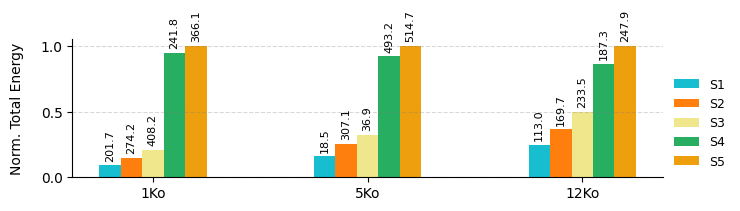

In [6]:
fig, ax = plt.subplots(figsize=(7.5, 2.2))  

for i, library in enumerate(libraries):
    
    subset = dfte[dfte['schema'] == library]
    bar_positions = positions + i * bar_width
    bars = ax.bar(
        bar_positions, 
        subset['mean_energys'], 
        width=bar_width, 
        label=library, 
        color=color_mapping[library]
    )

    for bar, std in zip(bars, subset['std_energy']):
        height = bar.get_height()
        ax.annotate(
            f'{std:.1f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=8, rotation=90
        )

ax = bar_ax_style(ax, "Norm. Total Energy")

# plt.xticks(rotation=360, ha='right')
plt.tight_layout()
plt.show()

In [10]:

times_features = [
    "process",
    "pull",
    "push"
]

# dftt : Data Frame Total Time 
dftt = (
    dfm.copy()
    .assign(
        total_time=lambda df: df[times_features].sum(axis=1)
    )
    .groupby(['schema', 'text'], as_index=False)['total_time']
    .agg(std_total_time='std', mean_time='mean')
    .assign(
        normalized_total_time=lambda df: df.groupby('text')['mean_time'].transform(max_abs_scale),
        text=lambda df: pd.Categorical(df['text'], categories=text_order, ordered=True),
    )
    .sort_values(['schema', 'text'])
)

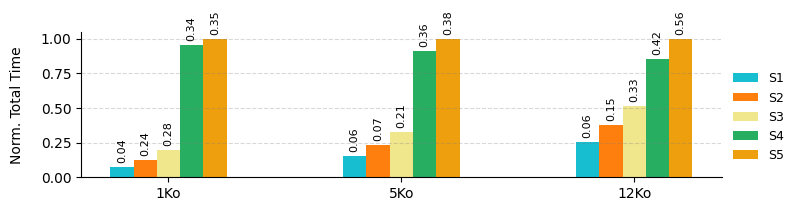

In [11]:
fig, ax = plt.subplots(figsize=(8, 2.2))

for i, library in enumerate(libraries):
    subset = dftt[dftt['schema'] == library]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['normalized_total_time'], width=bar_width, label=library, color=color_mapping[library])

    for bar, std in zip(bars, subset['std_total_time']):
        height = bar.get_height()
        ax.annotate(f'{std:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, rotation=90)

ax = bar_ax_style(ax, "Norm. Total Time")

plt.tight_layout()
plt.show()